# **COMP 2211 Exploring Artificial Intelligence** #
## Lab 6 Multilayer Perceptron ##
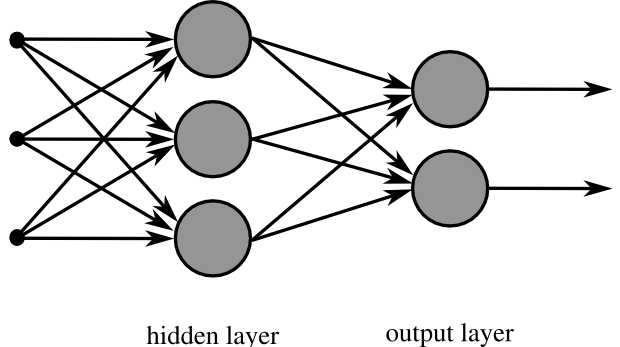

## **Submission to ZINC**
### After completing the missing functions in this notebook, successfully running the code, and achieving the task score requirement, please **COPY** your functions to the given .py file, zip it and submit **ONLY** the lab6_tasks.py.zip file to ZINC.

## Before We Begin ##

Run the code in the following two code cells to "mount" the Google drive directory.

## Mount Google Drive
Download and save a copy of the Lab6 files, including the Notebook, an excel file (i.e. *imdb.csv*) and the gzipped GloVe embeddings to your Google Drive, ensuring that all the files are in the same location.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "/content/drive/My Drive"

/content/drive/My Drive


### 1. Import the required libraries

In [ ]:
# You can import more module to use in later stage here, e.g. other initializers like GlorotUniform()
# But !REMEMBER! to add the import line(s) also in the .py file before submission
import pandas as pd
import numpy as np
import re
import keras

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from tensorflow.keras import regularizers
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.initializers import HeNormal
import matplotlib.pyplot as plt

### 2. Load and explore the data 

The dataset we use is the IMDb Movie Reviews, which contains binary sentiment labels of "positive" or "negative" corresponding to each review. The negative instances are sampled from review scores ≤ 4 (out of 10) while the positive instances are sampled from review scores ≥ 7 (out of 10).

In [ ]:
pd.set_option('display.max_colwidth', None)
df = pd.read_csv("imdb.csv")
df

,review,sentiment
0,"Nicolas Roeg's projects are variable to say the least, but are never less than interesting. ""Insignificance"" is obviously, first and foremost, an adapted stageplay: it's wordy and pretty-much 'room-bound'. BUT, it pays to view this film more than once: the underlying themes are not overtly presented and, what's more, it takes a while to adjust to the juxtaposition and role-reversals of the four protagonists: Einstein, McCarthy, Munroe, and DiMaggio. <br /><br />Einstein is wracked by guilt over Hiroshima yet fancies the simplicity of a sexual liaison with Munro; Munro is sick of being seen as a bimbo and craves intellectual credence; Senator McCarthy is at the height of his witch-hunting powers but is an impotent sleazebag; DiMaggio is insecure about his celebrity, self-obsessed, and prone to violence. Each of them contains the seeds of their own destruction. Each character has a troubled, abused/abusive past and a questionable future. Gradually, we see that obsession itself is the central theme. America's obsession with its postwar cultural icons and mores; the obsessions of the protagonists for something none can have: peace-of-mind and/or happiness.<br /><br />Compared with the theory of relativity, a proposed unified-field theory and, indeed, the cosmos itself, all the aspirations and interactions of Roeg's protagonists seem insignificant. Yet these aspects of the physical universe (it's all quantum, trust me!) affect us when they are applied to the development of the means to destroy us. Monroe's mention of the principle behind the neutron-bomb (without naming it as such) is not an anachronism per se, but can only be understood by a contemporary audience. Indeed, ALL the references within the script are only accessible to a knowledgeable viewer: one au fait with '50s occurrences/personality cults and how they affect us in the 21st century.<br /><br />This film and its screenplay are either very, very clever, or extremely opaque and pretentious. Ultimately, however, probably insignificant.<br /><br />live long and prosper :) <br /><br />",positive
1,"Its difficult to be too tough on Brad Sykes, a hard-working guy doing what he loves, there is an honesty about him that seems often lacking with other microbudget directors. Check out the minuscule crew credits on Camp Blood, there is none of the usual thanking everyone down to the pizza joint they ate in, its Brad and his buddies and thats it, no pretentious rubbish. Jennifer Ritchkoff isn't your average horror flick heroine, but does well enough for you to hardly notice, Bethany Zolt looks like a star and Joseph Haggerty is so funny it hurts. The Clown is hardly an original horror film bad guy, but the design is good, Shemp Moseley does a decent job of bringing him to life and the image clashes nicely with the rural backdrop. Camp Blood is horror as blue collar and basic as it gets, not a good thing, not a bad thing, just a thing.",negative
2,"Everything is idyllic in Suburbia when the little family moves in, as the father have got a new job in a computer company there. But no paradise would be complete without its snake. Strange things happens as the family joins the local country club without the husband, as it certainly holds secrets. The father is not a joiner, but pressure is on him to join, as everyone who is anything in the neighborhood and at work are members. Robert Urich's good guy part is a bit tepid, but Joanna Cassidy as good natured housewife turning nasty sizzles. Suspenseful and well-made chiller with a bitchy Susan Lucci as club chairperson. Look out for cult favorite Michael Berryman in a bit part as a valet. The movie captures the sense of paranoia and the special effects final is worth waiting for. I have seen this movie quite a few times.",positive
3,"And with those words one of the great movie publicity campaigns came to a conclusion. 'Garbo Talks' and she spoke those words in her first sound film, an adaption of the Eugene O'Neil

In [ ]:
# Check if any null value
df.isnull().values.any()

False

In [ ]:
# Check our target classification: binary classification (only value of positive & negative)
df['sentiment'].value_counts()

positive    22358
negative    22224
Name: sentiment, dtype: int64

### 3. Process the data

After exploring the data, we can see there are html tags $^{[1]}$ and some meaningless symbol in the data. Therefore, we need to do preprocessing to filter away the undesired content.

>[1]: They are keywords that defines how a webpage is displayed and formatted, examples are \<html\>, \<head\>, \<h1\> etc. You can view the html code of a webpage by right clicking it and choose "View Page Source".

In [ ]:
# Here, we use regular expression, which is out of the scope of this course.
# Input: single sentence string
# Return: preprocessed sentence string
def preprocessing(sentence):
    # Remove html tags
    tag = re.compile(r'<[^>]+>')
    sentence = tag.sub('', sentence)
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    # Remove single char
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

#### Task 1
Please use the above predefined preprocessing function to perform preprocessing on the dataset to separate the review content and label into variables X and y.

In [ ]:
def get_X_y(df):
  ##### TODO: preprocess all the instances in the dataset and store the processed list of sentence into variable X
  # X = a list of processed review strings

  ##### TODO: map the sentiment label into a binary value of 0 and 1 and store the binary numpy array into variable y
  # y = 1d binary numpy array

  ##### END of TODO
  return X,y

In [ ]:
X,y = get_X_y(df)

In [ ]:
# Split into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=3)

So far we have successfully obtained the list of preprocessed reviews in both X_train and X_test. Then, we need to split the review strings into list of words and map each of the word tokens into a unique index. Tokenizer in Keras will help to achieve this objective.

In [ ]:
# Tokenizer helps to map each word to a index, so after calling texts_to_sequence, the string of review will be transformed into a list of word index
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
# To reduce the complexity, we only look at the last 150 tokens of the review
maxlen = 150

# Pad to make sure each instance are having the same sequence len
# padding='post': pad zero after the sequence until the sequence len of the sample reaching maxlen
# truncating='pre'(default setting): truncate the tokens in the sequence that exceeding maxlen in descending order
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

Different pretrained GloVe embeddings can be downloaded from https://nlp.stanford.edu/projects/glove/. GloVe is an unsupervised algorithm using the word-word co-occurrence statistics to generate representation for different words. The one we are using here is generated from data of Wikipedia 2014 and Gigaword 5. 

Here we treat this embedding as a blackbox that turn each word into an array of size (100,) that retains the semantic relationship between words as illustrated below.
 
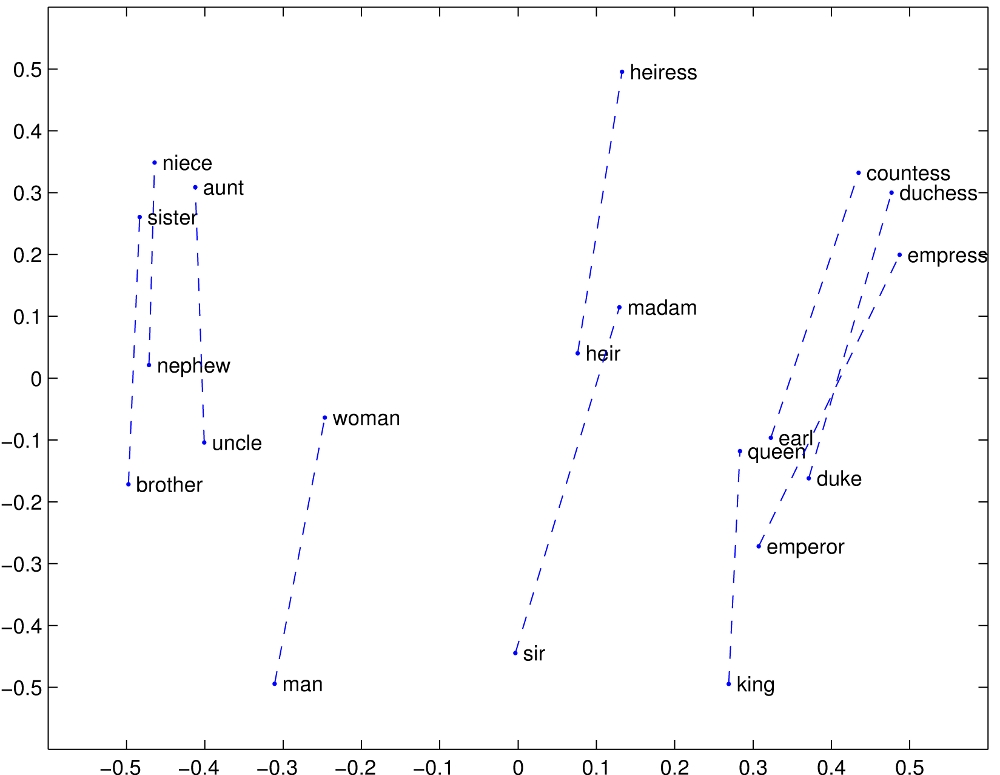

You can also look inside this paper (https://nlp.stanford.edu/pubs/glove.pdf) if you are interested to learn more about GloVe embedding.

In [ ]:
def readglovefile(filepath):
  import gzip
  with gzip.open(filepath,'r') as f:
    content=f.readlines()
  return [i.decode('utf8') for i in content]

In [ ]:
# Show the content in glove.6B.100d.txt file
readglovefile('glove.6B.100d.txt.gz')[:10]

['the -0.038194 -0.24487 0.72812 -0.39961 0.083172 0.043953 -0.39141 0.3344 -0.57545 0.087459 0.28787 -0.06731 0.30906 -0.26384 -0.13231 -0.20757 0.33395 -0.33848 -0.31743 -0.48336 0.1464 -0.37304 0.34577 0.052041 0.44946 -0.46971 0.02628 -0.54155 -0.15518 -0.14107 -0.039722 0.28277 0.14393 0.23464 -0.31021 0.086173 0.20397 0.52624 0.17164 -0.082378 -0.71787 -0.41531 0.20335 -0.12763 0.41367 0.55187 0.57908 -0.33477 -0.36559 -0.54857 -0.062892 0.26584 0.30205 0.99775 -0.80481 -3.0243 0.01254 -0.36942 2.2167 0.72201 -0.24978 0.92136 0.034514 0.46745 1.1079 -0.19358 -0.074575 0.23353 -0.052062 -0.22044 0.057162 -0.15806 -0.30798 -0.41625 0.37972 0.15006 -0.53212 -0.2055 -1.2526 0.071624 0.70565 0.49744 -0.42063 0.26148 -1.538 -0.30223 -0.073438 -0.28312 0.37104 -0.25217 0.016215 -0.017099 -0.38984 0.87424 -0.72569 -0.51058 -0.52028 -0.1459 0.8278 0.27062\n',
 ', -0.10767 0.11053 0.59812 -0.54361 0.67396 0.10663 0.038867 0.35481 0.06351 -0.094189 0.15786 -0.81665 0.14172 0.21939 0.58505 -

#### Task 2
We need to parse the glove.6B.100d.txt.gz file to a python dictionary storing each word and its corresponding vector representation. 

In [ ]:
def formatEmbDict(filepath):
  wordDict = {}
  content = readglovefile(filepath)
  ##### TODO: return a dict variable wordDict with [word as key] and [embedding as value]
  # i.e. calling wordDict['the'] will return a numpy array of [-0.038194, -0.24487, 0.72812, ..., 0.27062]


  ##### END of TODO
  return wordDict

In [ ]:
filepath = 'glove.6B.100d.txt.gz'
wordDict = formatEmbDict(filepath)

You can check your returned wordDict as below,

In [ ]:
wordDict['the']

array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2526  ,  0.071624,  0.70565 ,  0.49744 , 

Then we need to create an embedding matrix consisting of all the vector representations of the whole vocabulary set (i.e. the set of unique words) within the training set in the order of the Keras tokenizer indexing. This enables the input representation X_train and X_test (which contain the arrays of indexes corresponding to different words) to be transformed into a matrix of word representation in the model embedding layer (i.e. each word index is transformed to its GloVe vector representation).

In [ ]:
# Add 1 as 0 is a reserved index that won't be assigned to any word
vocab_size = len(tokenizer.word_index) + 1

# Store the embedding corresponding to each vocab (i.e. each specific word) into embedding matrix
embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
  # If there is no such word in wordDict, the get function will return None
  embedding_vector = wordDict.get(word)
  if(embedding_vector is not None):
    embedding_matrix[index] = embedding_vector

In [ ]:
# So we can see the embedding_matrix got shape of (90591, 100) for vocab size of 90591 and each vocab having a array size of (100,)
embedding_matrix.shape

(90591, 100)

### 4. Build the model

#### Task 3
After preprocessing the data, we need to define the model architecture.

In [ ]:
def myModel(vocab_size, embedding_matrix, maxlen):
  model = Sequential()
  # In embedding_layer, the word index array for each instance is transformed to the GloVe embedding according to the embeddings matrix
  embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
  model.add(embedding_layer)
  ##### TODO: please construct a MLP, you can try different setting your own
  # You will get the point of this part if 
  #       - your model gets a accuracy higher than 70% in our private test set
  #       - your model uses at least 2 and most 4 dense layers (including the output layer)
  #       - your model only uses the below listed keras modules (the model summary will be checked)
  # Here only expect the use of these keras modules:   Dense, Flatten, Activation, Dropout 
  # For your information, dropout is randomly setting input units to 0 during training to prevent overfitting, details can be found in https://keras.io/api/layers/regularization_layers/dropout/.
  # Remark: your model will be trained with 6 epoches under the same training setting as here (e.g. the same training set, training epoches, optimizer etc.) for evaluation, 
  #         you may (depends on how your model design) need to set some argument in the dense layer to prevent overfitting causing poorer result


  ##### END of TODO
  return model

In [ ]:
model = myModel(vocab_size, embedding_matrix, maxlen)

### 5. Compile the model

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
model.summary()

### 6. Train the model

In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
237/237 [==============================] - 9s 36ms/step - loss: 3.7321 - acc: 0.6221 - val_loss: 0.9034 - val_acc: 0.6649
Epoch 2/6
237/237 [==============================] - 7s 31ms/step - loss: 0.8392 - acc: 0.6559 - val_loss: 0.8228 - val_acc: 0.6298
Epoch 3/6
237/237 [==============================] - 7s 31ms/step - loss: 0.7184 - acc: 0.7015 - val_loss: 0.7186 - val_acc: 0.6788
Epoch 4/6
237/237 [==============================] - 7s 31ms/step - loss: 0.6578 - acc: 0.7326 - val_loss: 0.6521 - val_acc: 0.7312
Epoch 5/6
237/237 [==============================] - 7s 31ms/step - loss: 0.6231 - acc: 0.7531 - val_loss: 0.6453 - val_acc: 0.7310
Epoch 6/6
237/237 [==============================] - 7s 31ms/step - loss: 0.5985 - acc: 0.7666 - val_loss: 0.6329 - val_acc: 0.7398


You can visualize the training progress here and and check whether there is overfitting.

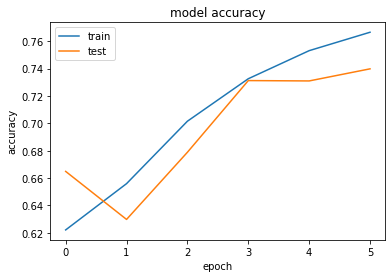

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

### 7. Evaluate the model accuracy

In [ ]:
# verbose=1: show the progress bar
score = model.evaluate(X_test, y_test, verbose=1)
print("Loss Score:", score[0])
print("Test Accuracy:", score[1])

209/209 [==============================] - 2s 7ms/step - loss: 0.6347 - acc: 0.7433
Test Score: 0.6347448825836182
Test Accuracy: 0.74327152967453


# Unmount Google Drive

In [ ]:
drive.flush_and_unmount()